# OxVent DVT6 Report

Conducted at Smith+Nephew's site in Hull, 26-29 June. With thanks to Ben Askem and Andrea Maggiore, who blocked out the entire period to perform these tests. 

Author: Tom Kirk (Oxford)

Data acquisition: Andrew Orr (Oxford), Ben Askem, Andrea Maggiore (S+N)

## Format of this report

This report contains the raw data that was acquired, the code that was used for analysis, and the results themselves. For each test that was performed, the discussion comes after the graph of results for that test, under the appropriate headings. The reader is not expected to go through the code, skip through to the results headings!

An IMT FlowAnalyser PF-3000 was used for all reference tidal volume measurements. All tests except [6.8 System startup](#6.8) were performed with three identical test lungs (resistance 20(?), compliance 17.7), whereas 6.8 was performed with a lung of variable compliance and set at 25 resistance. 

## Contents
- [6.1 Flow calibration](#6.1)
- [6.2 Spirometry kit variability](#6.2)
- [6.2.2 Spirometry kit variability, single valve](#6.2.2)
- [6.3 Tidal volume drift](#6.3)
- [6.4 Inspiration pressure](#6.4)
- [6.5 Achieveable therapy configuration](#6.5)
- [6.6 Low-flow control stability](#6.6)
- [6.7 Solenoid valve characterisation](#6.7)
- [6.8 System startup response](#6.8)
- [6.9 Tidal volume delivery](#6.9)
- [6.10 Ambu bag durability](#6.10)
- [6.11 Effect of temperature and humidity](#6.11)
- [6.12 Variation in supply voltage](#6.12)
- [6.13 Variation in supply pressure](#6.13)
- [Other observations](#other)

In [1]:
%matplotlib notebook

import loaders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import itertools

CMAP = plt.get_cmap('tab20')
ROOT = '../dvt6_data'
FIGSIZE = (9,6)
MARKSIZE = 20

## 6.1 Calibration of flow measurement <a id='6.1'></a>

A "ramp" test was performed: a flow controller was used to provide set flow rates through the patient airway kit as used on the OxVent system (smoothbore tube, Marshall valve, spiro kit, HMEF filter), venting to atmosphere. At each flow rate, there was a delay before logging data to ensure steady state conditions were achieved. Differential pressure readings were logged from the OxVent board over USB (16 bit values). 

22 OxVent boards were used, with 3 Marshall valve & spiro kit assemblies, evenly split across devices. This test was performed after [6.2 Spirometry kit](#6.2), from which 3 spiros with typical characteristics (2, 4, 5) were selected to perform this test. The suffix SP on the data refers to the spiro number used to test that board. 

As the differential pressure sensor records a non-zero reading for zero-flow, the data must be zero-shifted first (a zero reading was taken for each device to enable this).  

In [2]:
def zero_shift(data_dict):
    for n,df in data_dict.items(): 
        fltr = (df["flow"] == 0)
        zp = df.loc[fltr, "pressure"]
        df["pressure"] = df["pressure"] - zp.mean()
        data_dict[n] = df.loc[~fltr,:]    
    return data_dict 

In [3]:
flow_data = loaders.load(op.join(ROOT, 'flow_sensor'), 'SN.*_PRDW.dat', 9, ('time', 'pressure', 'flow'))
flow_data = zero_shift(flow_data)
flow_data['SN0990_SP4'][::40]

dict_keys(['SN0990_SP4', 'SN0915_SP2', 'SN0993_SP5', 'SN0986_SP5', 'SN1001_SP5', 'SN0920_SP2', 'SN0945_SP5', 'SN0839_SP4', 'SN0944_SP4', 'SN0987_SP2', 'SN0942_SP2', 'SN0926_SP4', 'SN0988_SP2', 'SN0912_SP5', 'SN0918_SP4', 'SN0924_SP4', 'SN0998_SP5', 'SN0916_SP4', 'SN0913_SP2', 'SN0995_SP5', 'SN0923_SP4', 'SN1002_SP2'])


,time,pressure,flow
0,31834.0,550.032258,100.0
40,42392.0,1233.032258,150.0
80,53079.0,1725.032258,200.0
120,63638.0,2292.032258,250.0
160,82308.0,3790.032258,350.0
200,92930.0,4495.032258,400.0
240,109528.0,5686.032258,450.0
280,140142.0,7666.032258,550.0
320,156738.0,8813.032258,600.0


In the ideal case we would get a quadratic relationship (Bernoulli's law), however it has previously been found that this gives a poor fit with the data, so we fit a more general relationship of the form $\Delta P = a f ^ n$, where $n$ is not constrained to be quadratic. The fit is performed over all data points from all devices (giving equal weight to each). Negative values caused by random noise at low flow need to be clipped out. 

In [4]:
all_fp = np.concatenate([ df.loc[:,["flow", "pressure"]] for df in flow_data.values() ], axis=0)

# Trim out rows with negative readings
all_fp = all_fp[all_fp[:,1] > 0,:]
(n, loga) = np.polyfit(np.log(all_fp[:,0]), np.log(all_fp[:,1]), 1)

a = np.exp(loga)
rms_error = np.sqrt(((all_fp[:,1] - (a * all_fp[:,0] ** n))**2).mean())
print("multiplier: %.6f, exponent: %.6f" % (a, n))
print("RMS error (normalised to mean signal) {:2.2f}%".format(100 * rms_error / all_fp[:,1].mean()))

multiplier: 0.391982, exponent: 1.580407
RMS error (normalised to mean signal) 9.34%


Plot the fit against the data. We use a different symbol for each spiro (so all boards that used the same spiro share symbols). 

<IPython.core.display.Javascript object>


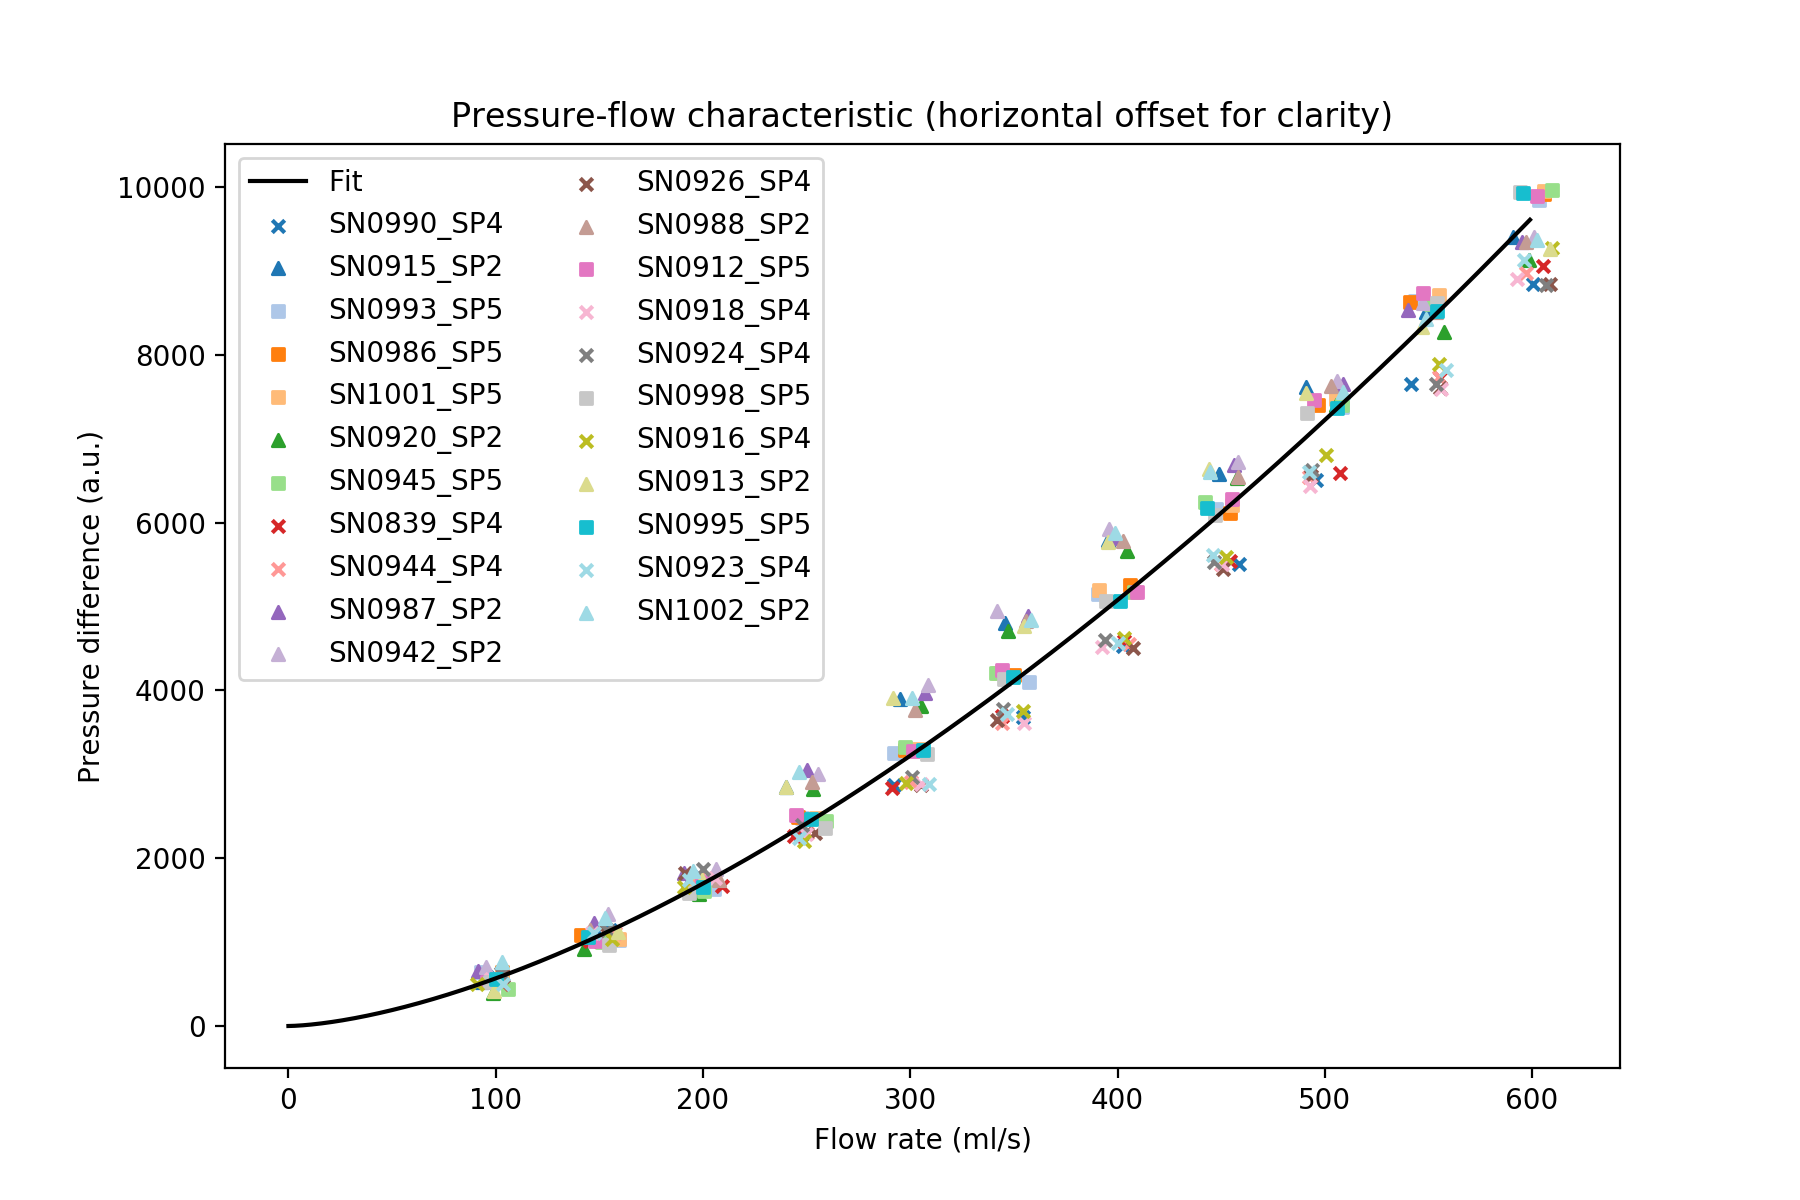

In [5]:
fig = plt.figure(figsize=FIGSIZE)
cmap = CMAP(np.linspace(0,1,len(flow_data)))[:,None,:]
symbols = { 'SP2': '^', 'SP4': 'x', 'SP5': 's' }

flow_range = np.arange(0, all_fp[:,0].max())
plt.plot(flow_range, a * (flow_range ** n), color='k', label='Fit')

for bidx,(bkey,bdf) in enumerate(flow_data.items()): 
    for flow in np.unique(bdf.loc[:,'flow']):
        y = bdf.loc[bdf["flow"] == flow, 'pressure'].mean()
        jitter = 10 * (np.random.uniform(-1,1))
        symbol = symbols[bkey[-3:]]
        if flow == 100:
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, label=bkey, marker=symbol)
        else: 
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, marker=symbol)
            
plt.legend(ncol=2)
plt.title("Pressure-flow characteristic (horizontal offset for clarity)")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.show()

### Calibration results

The symbols used for each datapoint correspond to the spiro that was used to obtain the data (ie, all the triangles were obtained with the same spiro). The fit was somewhat tighter than that of the [sprio variation test](#6.2) below (RMS error of 14.4% vs 9.3%). This is presumably explained by the fact that three spiros with neutral characteristics were used for this experiment, therefore reducing their contribution to variability. The variation of the differential pressure sensor itself can be characterised by looking within clusters of the same spiro: within-spiro variation is clearly smaller than between-spiro variation, as evidenced by the formation of separate clusters for each spiro with little overlap (particularly >300ml/s). In comparison to the previous calibration coefficients (obtained during the initial development at S+N), this fit gives a higher RMS error (9.3% vs 3.8%), but there are two important differences between this and the last calibration run: 
1. This fit was performed over a much larger dataset (22 OxVents and 3 spiros, whereas the last was performed with 4 OxVents, all of which used the same spiro) 
2. This fit was performed over a larger range of flow rates, whereas the last was over the range [0 400] ml

We previously used a weighting function to bias the fit in the range [200 300] ml; I tried the same here but it makes a marginal difference at best. After having derived these coefficients, we updated the 9 complete OxVent systems that were available to us in Hull to use them for all subsequent tests and found mixed results for their accuracy in general use. A fudge factor was still required, but it was around half the size of that previously (~10% as opposed to ~20%). By far and away the biggest cause for concern with the new calibration coefficients was significant overshoot/under-estimation at high tidal volumes (for example, for a target of 600ml, measuring 600 but delivering ~660). 

# 6.2 Spirometry kit variability <a id="6.2"></a>

The ramp test as used for [calibration](#6.1) was repeated here. Ten spiros was paired with ten Marshall valves and treated as integrated units (not separated subsequently). The same OxVent board was used for all sensors, and the suffix 'b' refers to repeat runs with the buzzer disabled on the board (to reduce electrical noise). 

In [6]:
spiro_data = loaders.load(op.join(ROOT, 'Spiro'), 'Spiro.*_PRDW', 5, ('time', 'pressure', 'flow'))
spiro_data = zero_shift(spiro_data)
spiro_data['Spiro_5'][::100]

dict_keys(['Spiro_5', 'Spiro_10b', 'Spiro_1', 'Spiro_9b', 'Spiro_4', 'Spiro_2', 'Spiro_7', 'Spiro_7b', 'Spiro_6', 'Spiro_10', 'Spiro_9', 'Spiro_3', 'Spiro_8'])


,time,pressure,flow
0,4795669.0,5.858974,100.0
100,4810159.0,1007.858974,150.0
200,4824718.0,1611.858974,200.0
300,4839207.0,2182.858974,250.0
400,4867775.0,4204.858974,350.0
500,4888295.0,5226.858974,400.0
600,4908754.0,5924.858974,450.0
700,4943292.0,8555.858974,550.0
800,4963751.0,10288.858974,600.0


As for the calibration, fit a relationship of the form $\Delta P = a f ^ n$, where the $n$ is not constrained to be quadratic (previous testing showed a quadratic gave a poor fit). *Note that this is not the same data that is used for deriving the flow calibration coefficients, though they obviously are very similar. The flow calibration coefficients are derived in [test 6.1](#6.1)*. Again, all data points were used in the fit with equal weighting, and negatives arising due to noise were filtered out. 

In [7]:
all_fp = np.concatenate([ df.loc[:,["flow", "pressure"]] for df in spiro_data.values() ], axis=0)

# Trim out rows with negative readings
all_fp = all_fp[all_fp[:,1] > 0,:]
(n, loga) = np.polyfit(np.log(all_fp[:,0]), np.log(all_fp[:,1]), 1)

a = np.exp(loga)
rms_error = np.sqrt(((all_fp[:,1] - (a * all_fp[:,0] ** n))**2).mean())
print("multiplier: %.6f, exponent: %.6f" % (a, n))
print("RMS error (normalised to mean signal) {:2.2f}%".format(100 * rms_error / all_fp[:,1].mean()))

multiplier: 0.141616, exponent: 1.736166
RMS error (normalised to mean signal) 14.44%


Plot this fit against the data

<IPython.core.display.Javascript object>


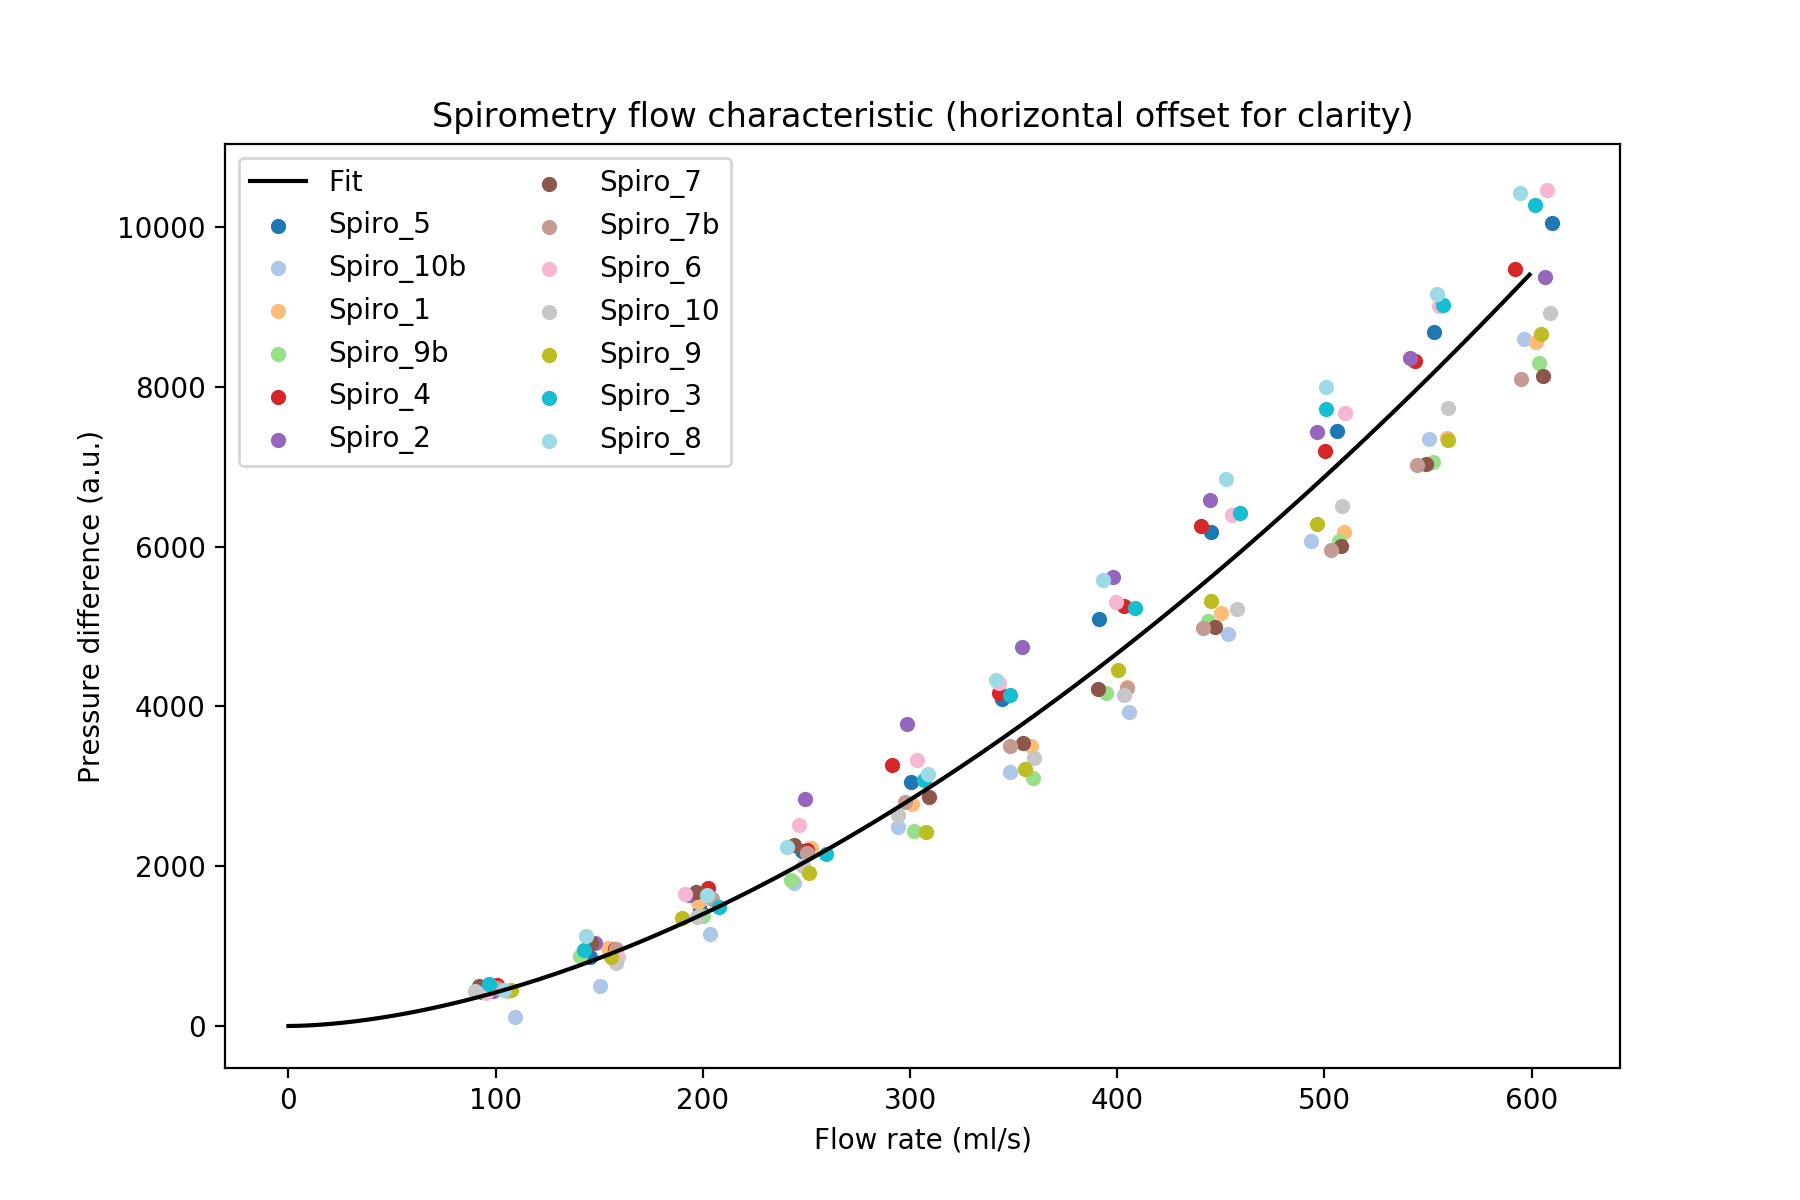

In [8]:
fig = plt.figure(figsize=FIGSIZE)
cmap = CMAP(np.linspace(0,1,len(spiro_data)))[:,None,:]

flow_range = np.arange(0, all_fp[:,0].max())
plt.plot(flow_range, a * (flow_range ** n), color='k', label='Fit')

for bidx,(bkey,bdf) in enumerate(spiro_data.items()): 
    for flow in np.unique(bdf.loc[:,'flow']):
        y = bdf.loc[bdf["flow"] == flow, 'pressure'].mean()
        jitter = 10 * (np.random.uniform(-1,1))
        if flow == 100:
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, label=bkey)
        else: 
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE)
            
plt.legend(ncol=2)
plt.title("Spirometry flow characteristic (horizontal offset for clarity)")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.show()

### Spirometry kit results

The plot clearly shows that spiro variation is much more significant than anticipated. As a rough example, at nominal settings of 400ml at 1:2 IE ratio, 20 RR, the required inspiratory flow rate is 400ml/s. The lowest/highest spiro readings at this flow were 3880 and 5650 respectively. Using the overall fit for all spiros, these extremes map to flows of 360ml/s and 450ml/s respectively, which is a range of almost ±50ml/s around the true value. Given this, it is logical to ask how the system has managed to function relaibly thus far (observed variability has not been this pronounced). My guess is that the spiros behave differently in actual use compared to ramp test used in this experiment. The process of ramping up to fixed flow rates and holding constant for a few secs is completely different to the flow profile seen during inspiration. The rate at which flow changes during inspiration is also relatively fast (aka 'stiff') compared to the sampling resolution of the system (we previously had issues related to the sampling rate being too low). I think these two effects (quickly varying flow profile, relatively coarse sampling resolution) combine to give different system behaviour in actual use. 

The particularly concerning result here was the emergence of a possible bi-modal distribution above 350ml/s (the spiros split into 2 groups). Note also that the repeat runs without buzzer (eg 7 vs 7b) actually show little difference: though the buzzer is a significant source of noise when examined with an oscilloscope, this result suggests that it is normally distributed and hence averages out over many samples. 

## 6.2.2 Spiro variation, single valve <a id='6.2.2'></a>

The [previous experiment](#6.2) was performed with unique pairs of spiro and Marshall valve. The procedure was repeated here with 5 sprios and a signle Marshall valve used for all (and the same OxVent board). The aim was to investigate the Marshall valve as a source of variability. 

In [9]:
spiro_data_single_valve = loaders.load(op.join(ROOT, 'Spiro_variation'), 
                                        'spivar.*_PRDW', 5, ('time', 'pressure', 'flow'))
spiro_data_single_valve = zero_shift(spiro_data_single_valve)
spiro_data_single_valve['spivar_s12'][::50]

dict_keys(['spivar_s12', 'spivar_s10', 'spivar_s11', 'spivar_s5', 'spivar_s13'])


,time,pressure,flow
0,5707264.0,383.0,100.0
50,5718533.0,979.0,150.0
100,5737849.0,2260.0,250.0
150,5755081.0,3265.0,300.0
200,5786392.0,5384.0,400.0
250,5817703.0,7673.0,500.0
300,5834936.0,8875.0,550.0


Plot against the fit derived in [test 6.2](#6.2) over all data points

<IPython.core.display.Javascript object>


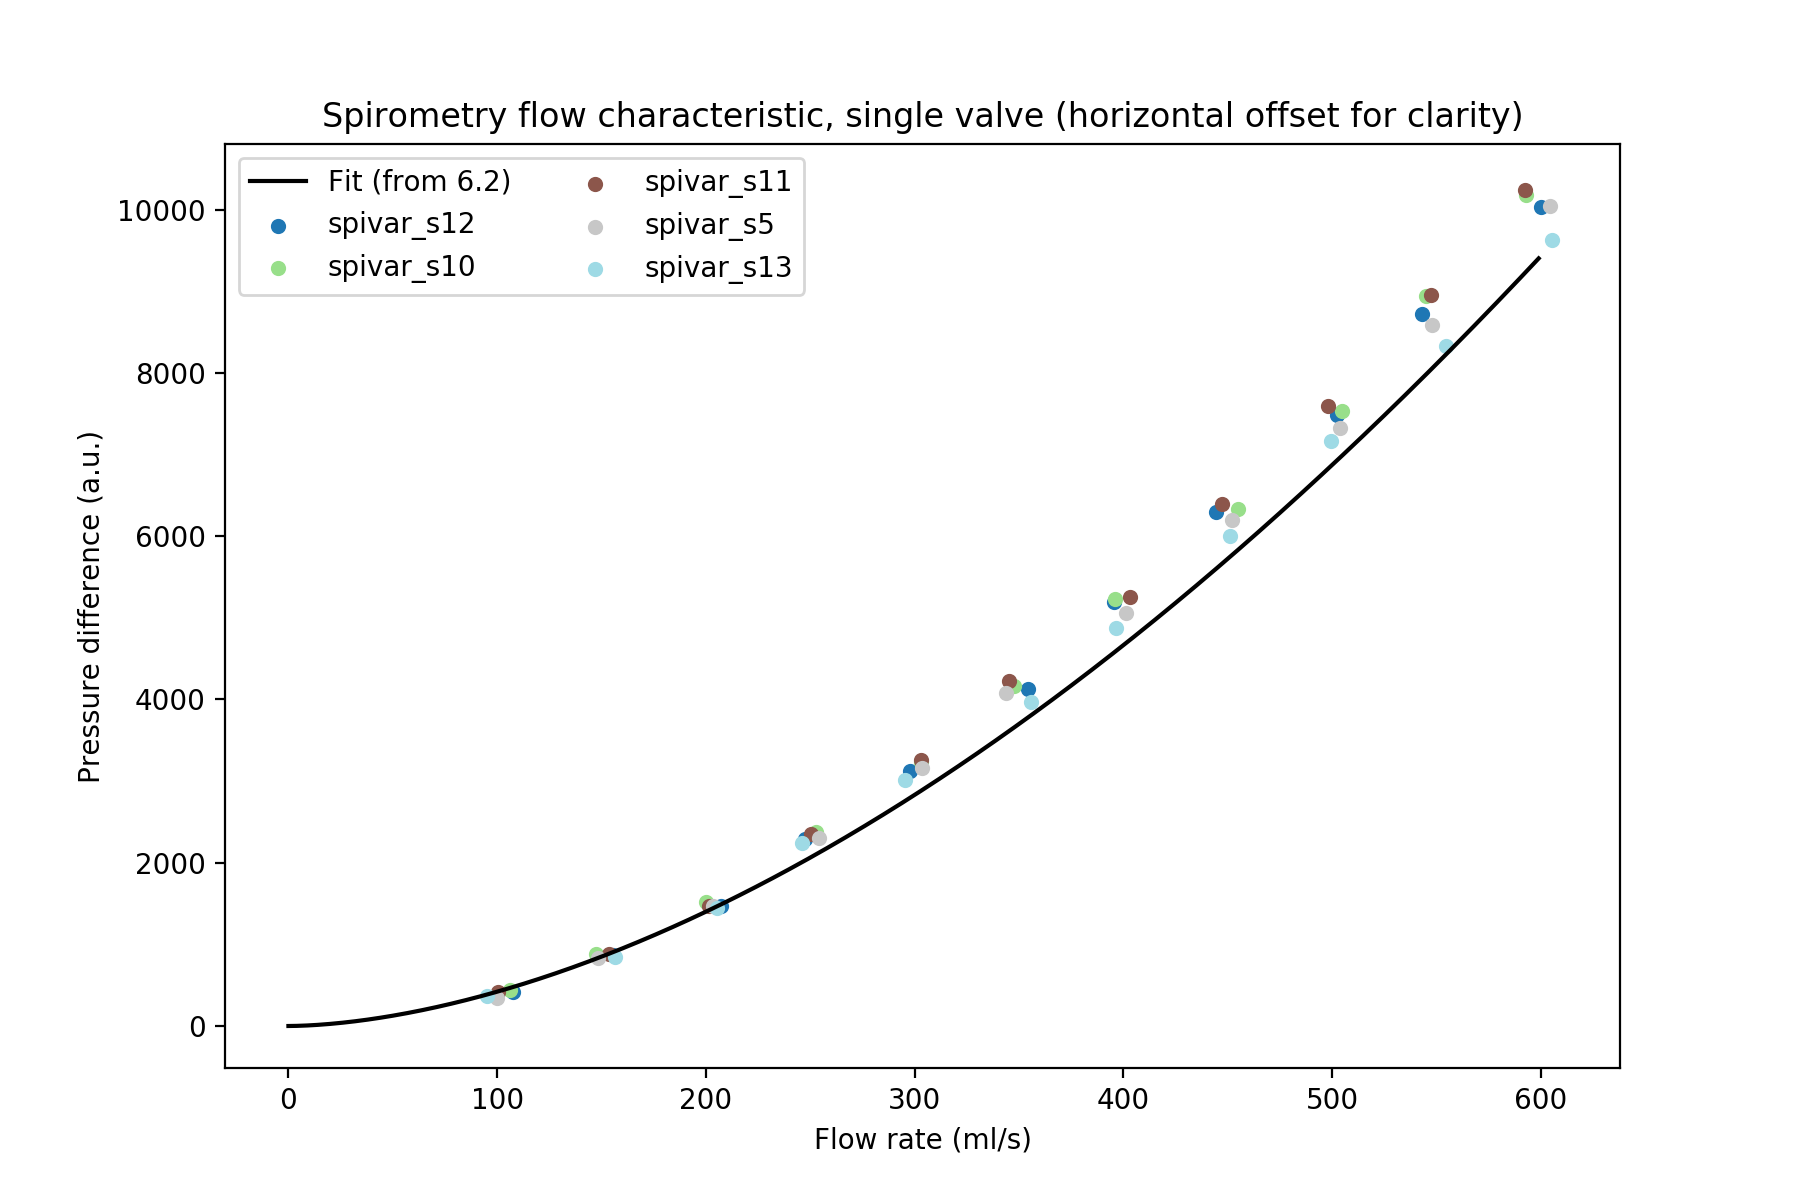

In [10]:
plt.figure(figsize=FIGSIZE)
cmap = CMAP(np.linspace(0,1,len(spiro_data_single_valve)))[:,None,:]
plt.plot(flow_range, a * (flow_range ** n), color='k', label='Fit (from 6.2)')

for bidx,(bkey,bdf) in enumerate(spiro_data_single_valve.items()): 
    for flow in np.unique(bdf.loc[:,'flow']):
        y = bdf.loc[bdf["flow"] == flow, 'pressure'].mean()
        jitter = 15 * (np.random.uniform() - 0.5)
        if flow == 100:
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, label=bkey)
        else: 
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE)
            
plt.legend(ncol=2)
plt.title("Spirometry flow characteristic, single valve (horizontal offset for clarity)")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.show()

### Spiro variation, single valve results

The continued presence of variability for a fixed choice of Marshall valve implies that spiro variability did contribute to the results seen in [test 6.2](#6.2). We did not repeat this test with multiple Marshall valves and a fixed choice of spiro, so it is possible that the same statement could be made of the Marshall valves. 

## 6.3 Tidal volume drift <a id='6.3'></a>

This test needs to be run in Oxford. We did have one unit running at 600ml, RR 27, IE ratio 1:2, 10 PEEP throughout our time in Hull and no drift was observed. 

## 6.4 Inspiration pressure <a id='6.4'></a>

The purpose of this test was to determine whether improvements can be made to system pressure measurement. An OxVent was set at nominal settings: 400ml, 20 RR, IE 1:2, 37 Plimit, 10 PEEP and pressure readings (as measured by the internal sensor) were logged over USB. Simultaneously, a scope was used to log the voltage from the same sensor (the raw output of the pressure sensor). 

Load the scope data:

In [11]:
scope_pinsp = loaders.load(op.join(ROOT, 'pinsp'), '.*.csv', 6, ('time', 'voltage'), skip_header=3)['scope']
scope_pinsp = scope_pinsp.loc[:scope_pinsp.shape[0]//2,:]
scope_pinsp[::150]

dict_keys(['scope'])


,time,voltage
0,-7.84,1.2711
150,-6.34,1.3103
300,-4.84,1.2788
450,-3.34,1.2551
600,-1.84,1.2921
750,-0.34,1.2567
900,1.16,1.3009


Load the OxVent data. Note that the two traces have different units in both time voltage/pressure (due to different sampling rates, and the different variable being measured). 

In [12]:
oxv_pinsp = loaders.load(op.join(ROOT, 'pinsp'), 'OxVent_2020-05-28-17-21-25_PRGR.dat', 
                         29, ('time', 'pressure', 'na'))['OxVent'].iloc[:,:2]
oxv_pinsp[::50]

dict_keys(['OxVent'])


,time,pressure
0,64033.0,42270.0
50,65450.0,33623.0
100,66849.0,40997.0
150,68289.0,33940.0
200,69680.0,39443.0
250,71126.0,33869.0
300,72511.0,36905.0
350,73964.0,34095.0


In order to get the two traces to match up, we need to shift the data in time and scale the data to map voltage to pressure. A zero-point calibration was used: if we assume that the minimum voltage corresponds to the minimum pressure, we can use that to work out a scaling factor that applies to all other voltage values. Previous work has confirmed that the static pressure sensor in the OxVent does have a linear characteristic, so we should see the maximum values correspond to each other after scaling. 

<IPython.core.display.Javascript object>


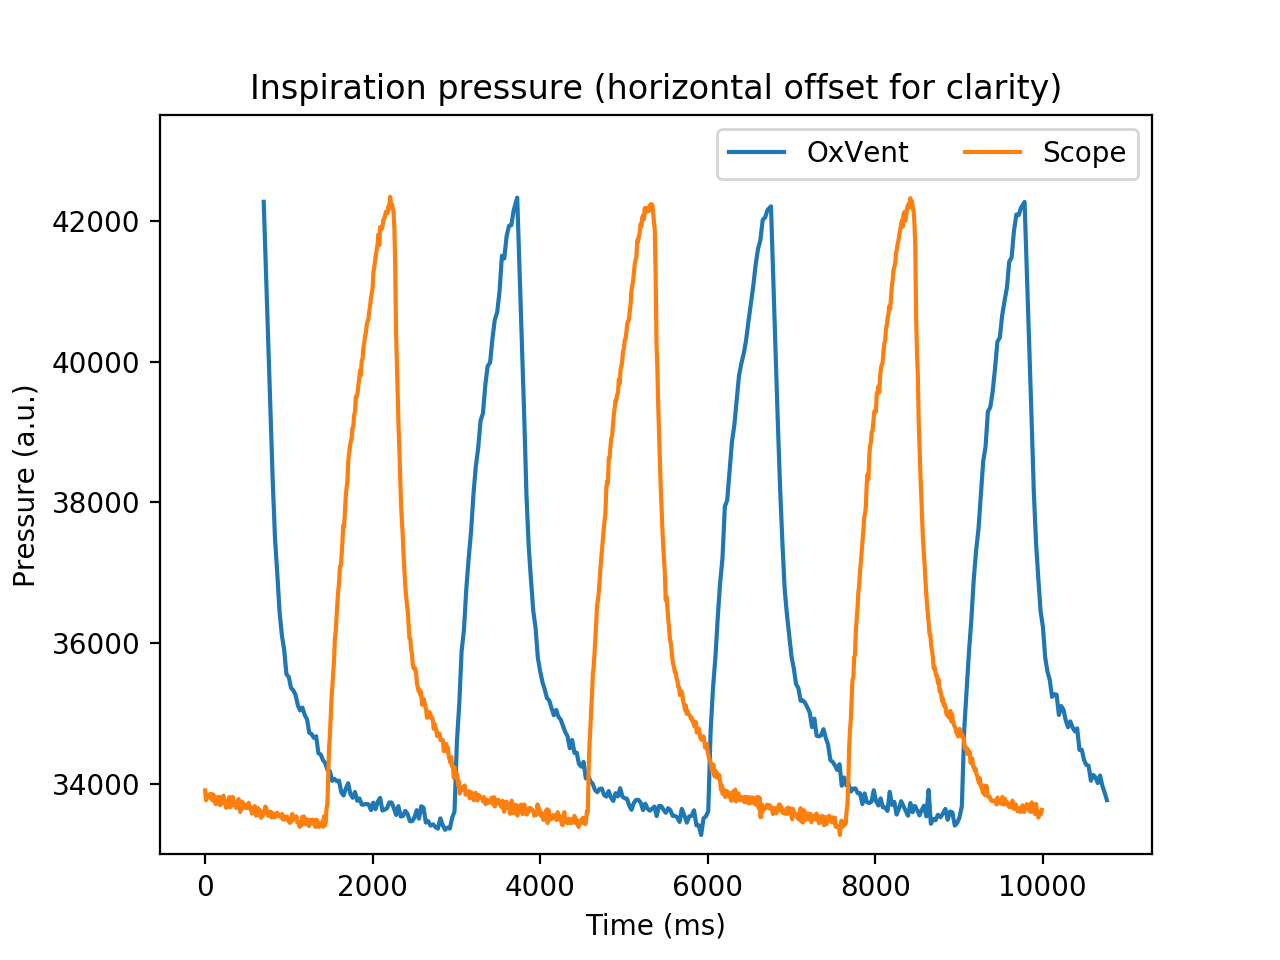

In [13]:
min_adc = oxv_pinsp.min(0)
min_scope = scope_pinsp.min(0)
scope_pinsp.loc[0,"time"]

fig = plt.figure()
plt.plot(oxv_pinsp.loc[:,"time"] - oxv_pinsp.loc[0,"time"] + 700, 
         oxv_pinsp.loc[:,"pressure"], label='OxVent')
plt.plot((scope_pinsp["time"] - scope_pinsp.loc[0,"time"]) * 1000, 
          scope_pinsp["voltage"] * min_adc[1] / min_scope['voltage'], label='Scope')

plt.legend(ncol=2)
plt.ylabel("Pressure (a.u.)")
plt.xlabel("Time (ms)")
plt.title("Inspiration pressure (horizontal offset for clarity)")
plt.ylim(33000, 43500)
plt.show()

### Inspiration pressure results

As can be seen from the plot, there was excellent agreement between the two traces, so we conclude that the OxVent is measuring pressure with sufficient frequency to accurately capture the dynamics of respiration. 

## 6.5 Achievable therapy configuration <a id='6.5'></a>

The purpose of this test was to determine what settings (VT, RR, IE) the system can reliably operate at. As the configuration space is large, we restricted ourselves to investigating high-flow configurations (though we have since found that low-flow configurations can also be challenging). 3 devices were tested at different VT, RR and IE ratio, which can in turn be reduced down to two independent variables: inspiratory flow rate (ml/s) and expiration time (s). Plimit was set at 45 to minimise the chance of pressure-limiting behaviour. 

In [14]:
therapy_data = pd.read_excel(op.join(ROOT, 'therapy', 'oxvent_air_rates.xlsx'), skiprows=1, usecols='A:N')
therapy_data = therapy_data.loc[(~therapy_data.isna()).all(1),:]
therapy_data

,Tidal Volume,Resp Rate,I:E Ratio (1:X),Cycle Time (s),Insp. Time (s),Exp. Time (s),Insp. Rate (ml/s),Exp. Rate (ml/s),06 Achieved,06 Ppeak,03 Achieved,03 Ppeak,05 Achieved,05 Ppeak
17,600,30,2,2.00,0.67,1.33,900.00,450.00,535.0,35.0,575.0,39.0,600.0,43.0
21,600,22,3,2.73,0.68,2.05,880.00,293.33,545.0,35.0,600.0,36.0,600.0,42.0
26,600,28,2,2.14,0.71,1.43,840.00,420.00,560.0,36.0,600.0,43.0,600.0,41.0
27,450,28,3,2.14,0.54,1.61,840.00,280.00,410.0,34.0,435.0,39.0,450.0,40.0
29,500,25,3,2.40,0.60,1.80,833.33,277.78,455.0,35.0,485.0,38.0,500.0,41.0
30,550,30,2,2.00,0.67,1.33,825.00,412.50,540.0,34.0,550.0,38.0,550.0,39.0
31,600,27,2,2.22,0.74,1.48,810.00,405.00,600.0,37.0,600.0,38.0,600.0,39.0
32,450,27,3,2.22,0.56,1.67,810.00,270.00,440.0,33.0,450.0,36.0,450.0,37.0
34,400,30,3,2.00,0.50,1.50,800.00,266.67,390.0,32.0,395.0,35.0,400.0,36.0
35,500,24,3,2.50,0.63,1.88,800.00,266.67,480.0,35.0,500.0,37.0,500.0,38.0


Each row in the table is a unique pair of (inspiratory flow rate, expiratory time) [the latter is bag re-inflation time]. For the three devices tested, we pick the one that achieved the lowest tidal volume and calculate the error as percent of target to give performance in the worst-case scenario. Plot a contour map of tidal volume error across the configuration space. As we did not sweep the space uniformly (nor did we sweep the whole space), triangulation is used to fill in the missing values (which may not be accurate as a result). The acquired datapoints are plotted in black for clarity. 

<IPython.core.display.Javascript object>


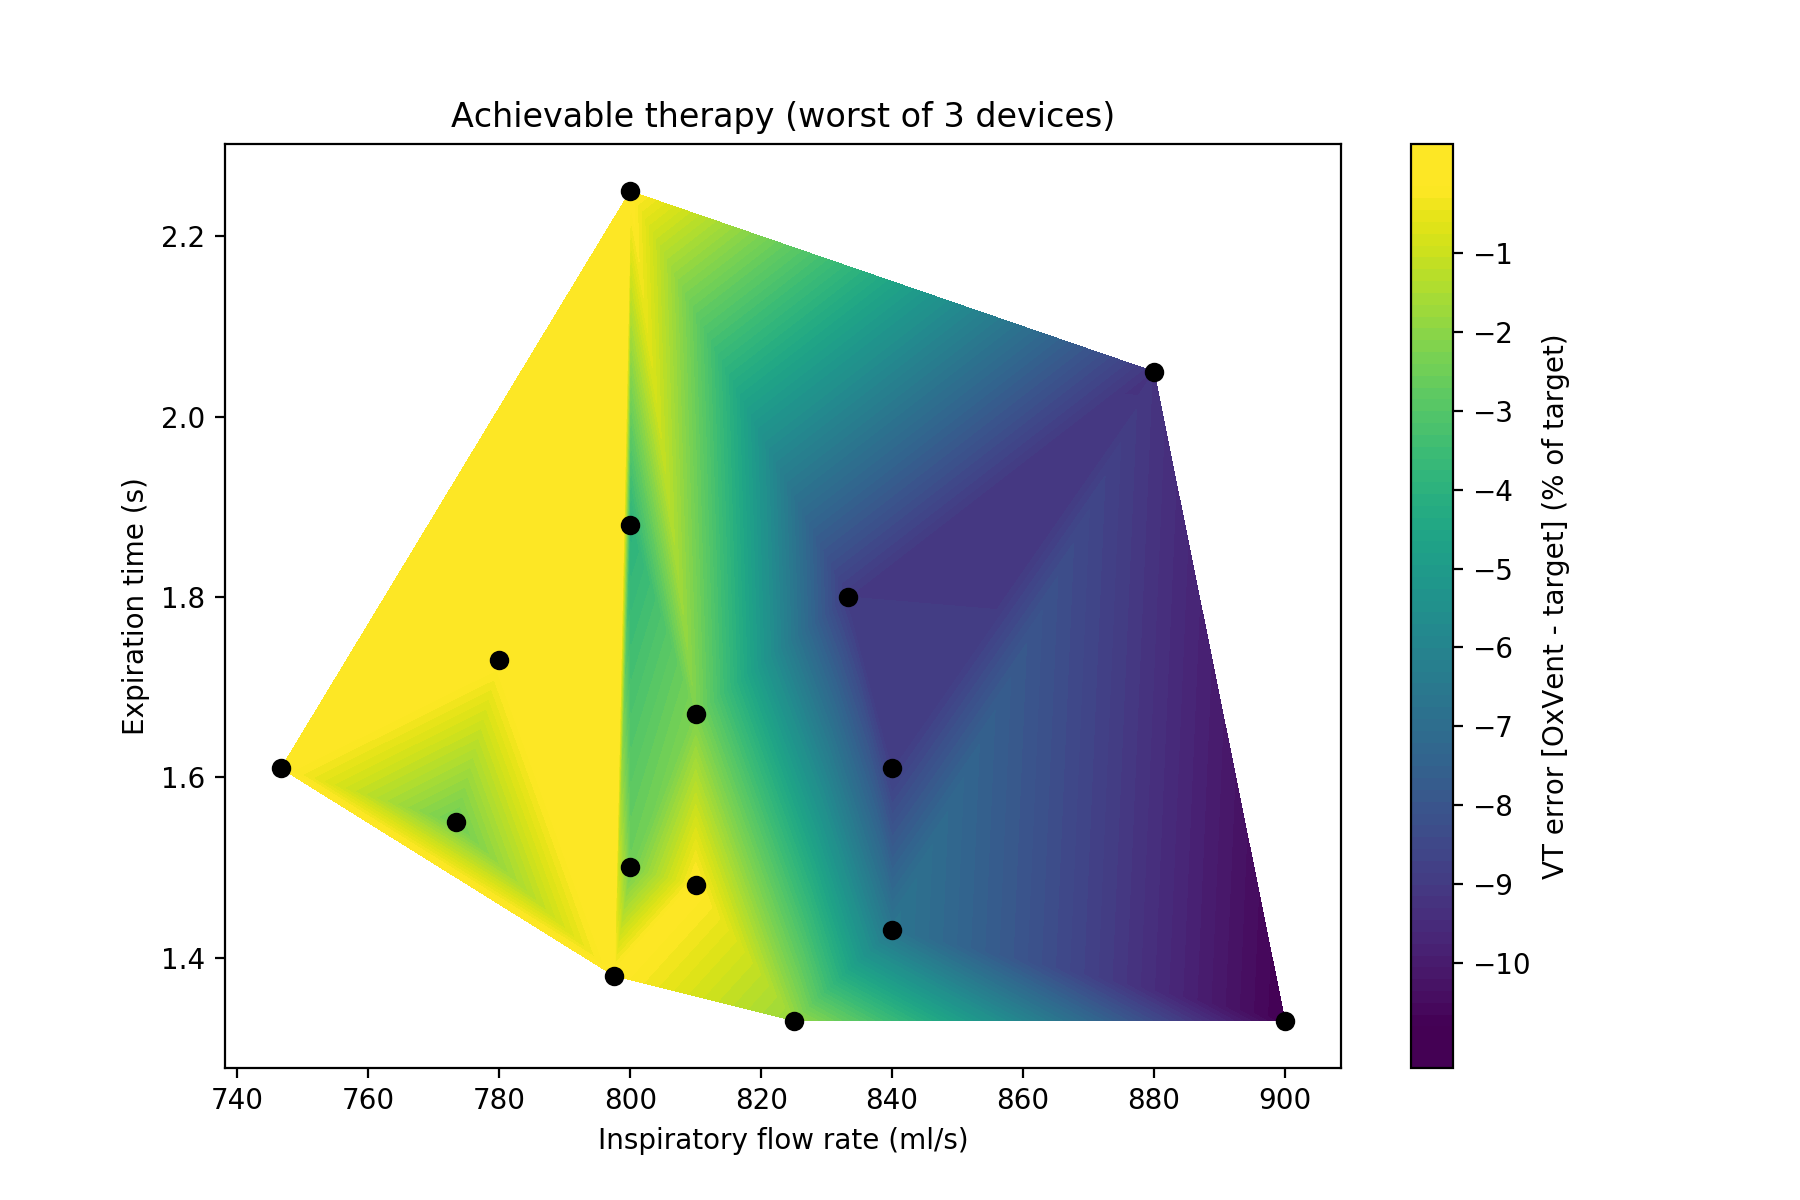

In [15]:
min_volume = therapy_data.filter(regex='Achieved').min(1)
vol_error = 100 * (min_volume - therapy_data["Tidal Volume"]) / therapy_data["Tidal Volume"]

fig = plt.figure(figsize=FIGSIZE)
x = therapy_data["Insp. Rate (ml/s)"].values
y = therapy_data["Exp. Time (s)"].values
plt.tricontourf(x, y, vol_error.values, 100, extend='both')
plt.colorbar(extendrect=True, ticks=range(0,-11,-1), label='VT error [OxVent - target] (% of target)')
plt.scatter(x, y, c='k')

plt.xlabel("Inspiratory flow rate (ml/s)")
plt.ylabel("Expiration time (s)")
plt.title("Achievable therapy (worst of 3 devices)")
plt.show()

### Achievable therapy configuration results 

Unsurprisingly, increasingly poor operation was seen as flow rates increased and expiration time decreased (towards the bottom RHS of the plot). This is because either a) the system cannot compress the bag quickly enough to deliver the required flow (either due to a lack of available pressure in the supply line, or due to pressure-limiting for patient safety), or b) the bag may not have had sufficient time to re-inflate for the next cycle. There is a notable ridge at 800ml/s that separates the region of accetable operation from the region of steadily deteriorating operation (flows > 800). 

## 6.6 Low-flow control stability <a id='6.6'></a>

How consistent is tidal volume delivery over 50 consecutive cycles at 250ml, RR 14, 1:1 IE ratio?

In [16]:
low_data = loaders.load(op.join(ROOT, 'lowflow'), '.*', 4, ('cycle', 'target', 'oxvent'))
low_data = low_data['lowflow_50'].iloc[:,1:]
low_data[::10]

dict_keys(['lowflow_50'])


,target,oxvent
0,250.0,263.0
10,250.0,247.0
20,250.0,241.0
30,250.0,220.0
40,250.0,243.0


<IPython.core.display.Javascript object>


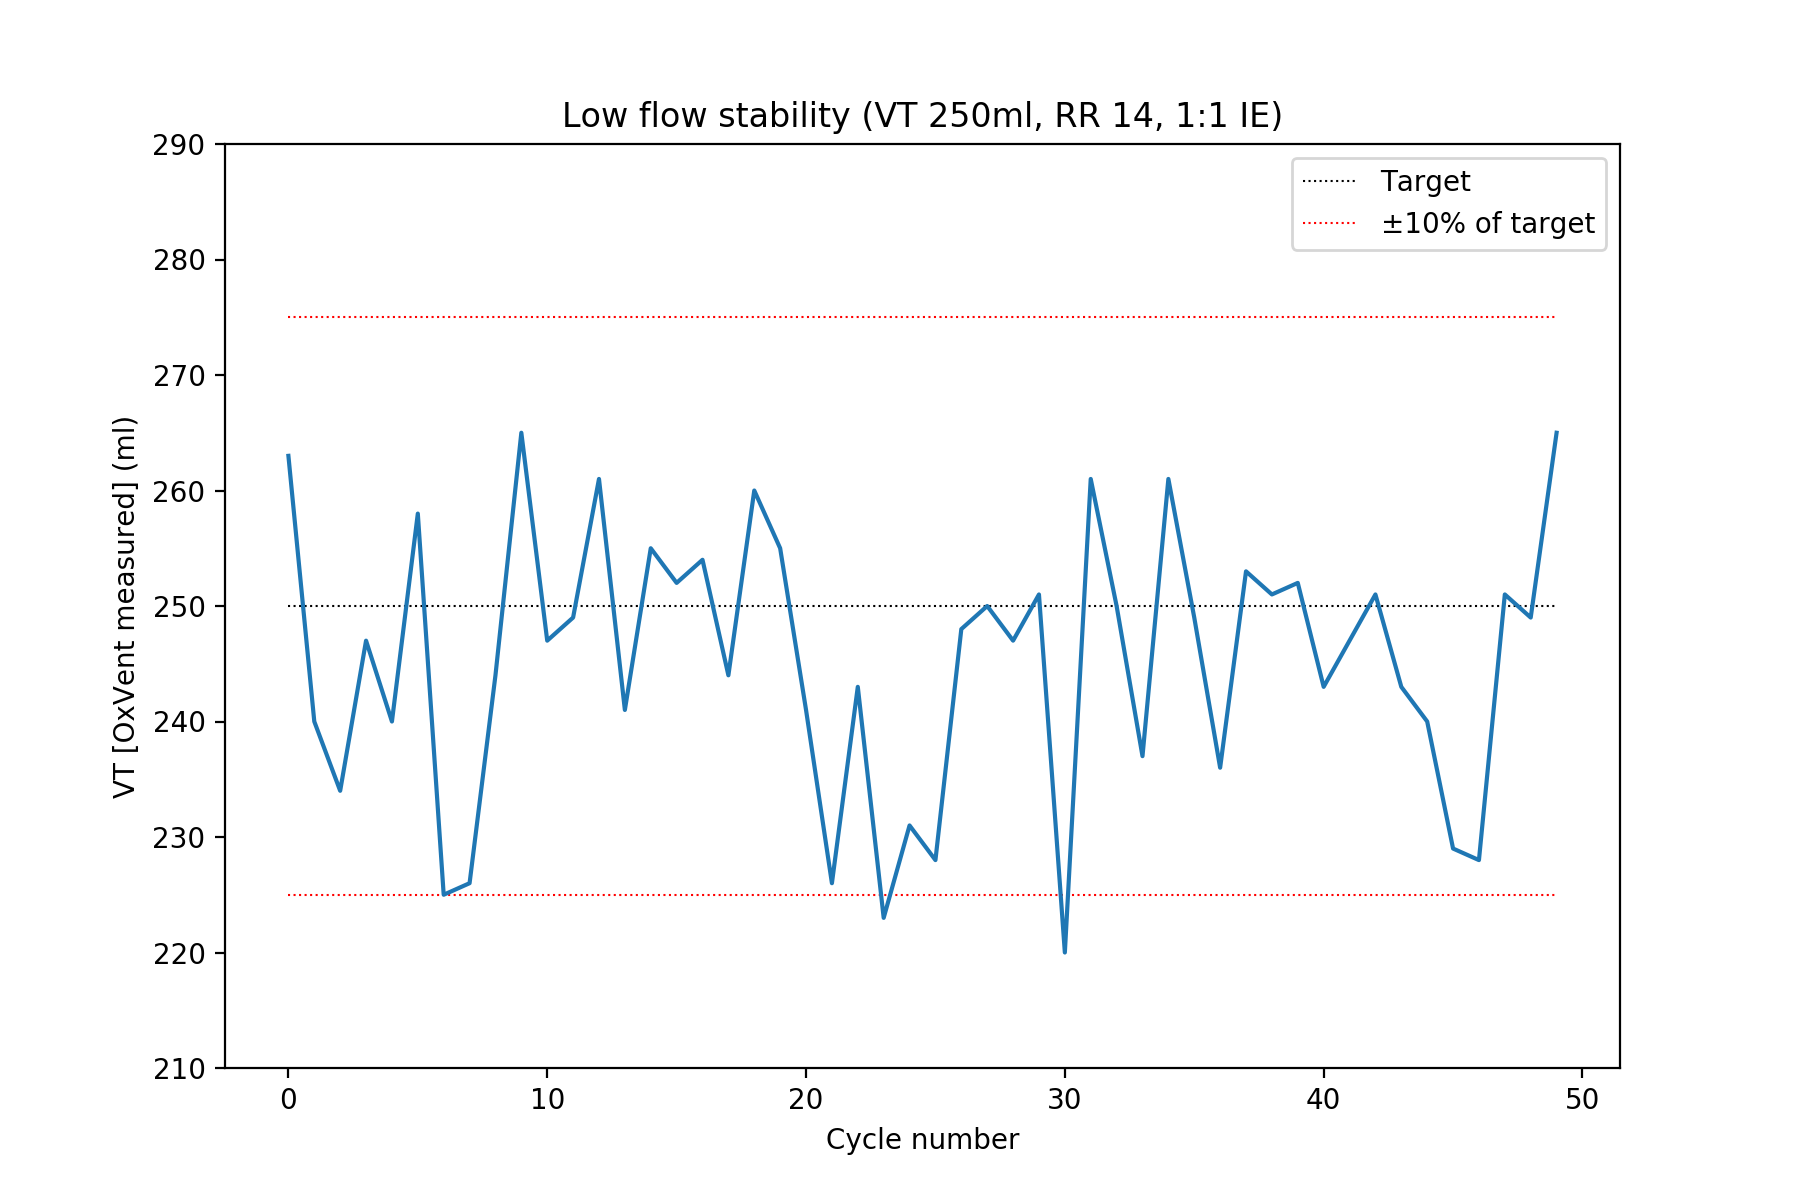

In [17]:
fig = plt.figure(figsize=FIGSIZE)

plt.plot(low_data.index, low_data['target'], 'k:', linewidth=0.75)
for percent in [0.9, 1.1]:
    plt.plot(low_data.index, low_data['target'] * percent, 'r:', linewidth=0.75)

plt.legend(['Target', '±10% of target'])
plt.plot(low_data["oxvent"].values)
plt.ylim(210,290)
plt.title("Low flow stability (VT 250ml, RR 14, 1:1 IE)")
plt.xlabel("Cycle number")
plt.ylabel("VT [OxVent measured] (ml)")
plt.show()

In [18]:
print("Std dev:", low_data["oxvent"].std())
print("Min delivery:", low_data["oxvent"].min())

Std dev: 11.640955147009795
Min delivery: 220.0


### Low-flow results 

The dashed red lines on the above plot denote ±10% around the target of 250ml. Generally the system was well within this range, erring slightly on the low side, and the largest deviation from target was 30ml (220ml delivered). Standard deviation of delivery was ±11.6ml. 

## 6.7 Solenoid valve characterisation <a id='6.7'></a>

The purpose of this test was to derivet the current-flow relationships of the two available solenoid valves (Burkert and SMC). A ramp test was performed with steadily increasing currents supplied to the valves and an inline flow meter was used to record outputs. Note that the other datasets in this folder (without suffix \_dual) were acquired with a single inline flow meter, which was found to restrict max flow for both valves at high current. The \_dual runs were repeated with parallel paths to correct for this and are presented below.   

In [19]:
valve_data = loaders.load(op.join(ROOT, 'valve'), 'VALVE_[a-z].*', 13, ('current', 'flow'))
valve_data['VALVE_smc'][::5]

dict_keys(['VALVE_smc', 'VALVE_burkert'])


,current,flow
0,110.0,0.00337
5,120.0,0.01267
10,130.0,2.71813
15,140.0,9.14812
20,150.0,15.88459
25,160.0,25.32356
30,170.0,29.44803


<IPython.core.display.Javascript object>


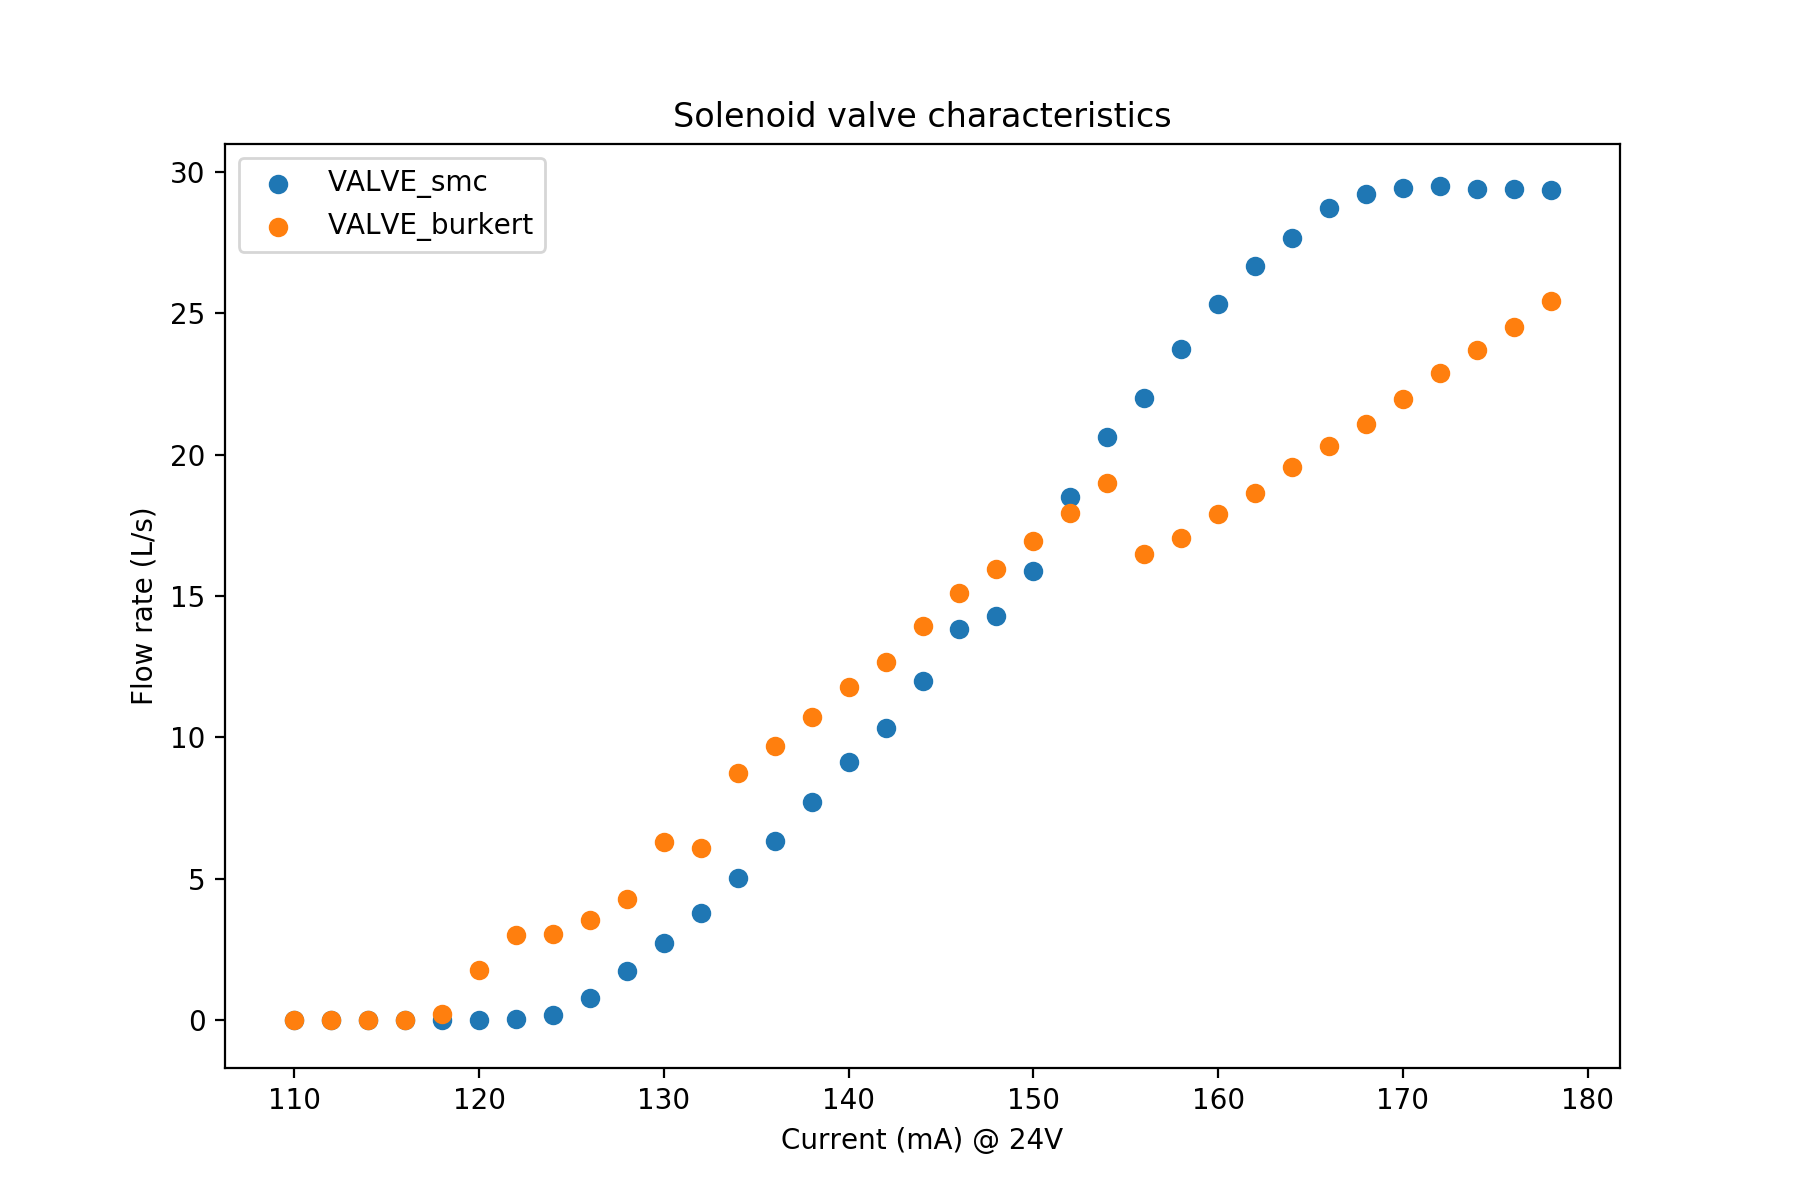

In [20]:
fig = plt.figure(figsize=FIGSIZE)
for idx,(vid,vdf) in enumerate(valve_data.items()): 
    plt.scatter(vdf["current"].values, vdf["flow"].values, label=vid)
plt.legend()
plt.title("Solenoid valve characteristics")
plt.xlabel("Current (mA) @ 24V")
plt.ylabel("Flow rate (L/s)")
plt.show()

### Solenoid valve results

The SMC trace is markedly smoother across the current range than the SMC valve. The noise at \~125mA on the Burkert trace may have been due to movement of the apparatus, but the cause of the disjoint at 155mA is unknown. Although the 'switch-on' point of the Burkert comes before that of the SMC (\~115 mA vs 125mA, though there is variation between valves of the same type), the SMC has a stronger response (greater increase in flow for fixed increase in current) and allows higher max flow rates when saturated. The Burkert seems to have a physically smaller aperture internally, which means the maxiumum flow rate it can deliver in the configuration tested here is smaller, which ultimately means OxVents with this valve *cannot deliver high-stress ventilation (eg 600ml @ 25 RR)*. It is for this reason that we strongly recommend using only SMC valves in the future. 

## 6.8 System startup response  <a id='6.8'></a>

For a given tidal volume and lung compliance, how quickly does the system achieve target operation from startup? Nominal settings were used (20 RR, 1:2 IE ratio, 10 PEEP). 

In [21]:
lowflow_data = loaders.load(op.join(ROOT, 'startup'), '.*.csv', 4, 
                          ('cycles', 'target', 'compliance', 'reference', 'oxvent'), skip_header=1)['68_PID']
lowflow_data[::25]

dict_keys(['68_PID'])


,cycles,target,compliance,reference,oxvent
0,1.0,250.0,10.0,68.0,54.0
25,26.0,250.0,10.0,250.0,268.0
50,21.0,450.0,10.0,473.0,451.0
75,16.0,600.0,10.0,522.0,508.0
100,11.0,250.0,30.0,209.0,192.0
125,6.0,450.0,30.0,398.0,385.0
150,1.0,600.0,30.0,582.0,675.0


Plot tidal volume for each cycle after startup, with separate traces for each (target, compliance) pair

<IPython.core.display.Javascript object>


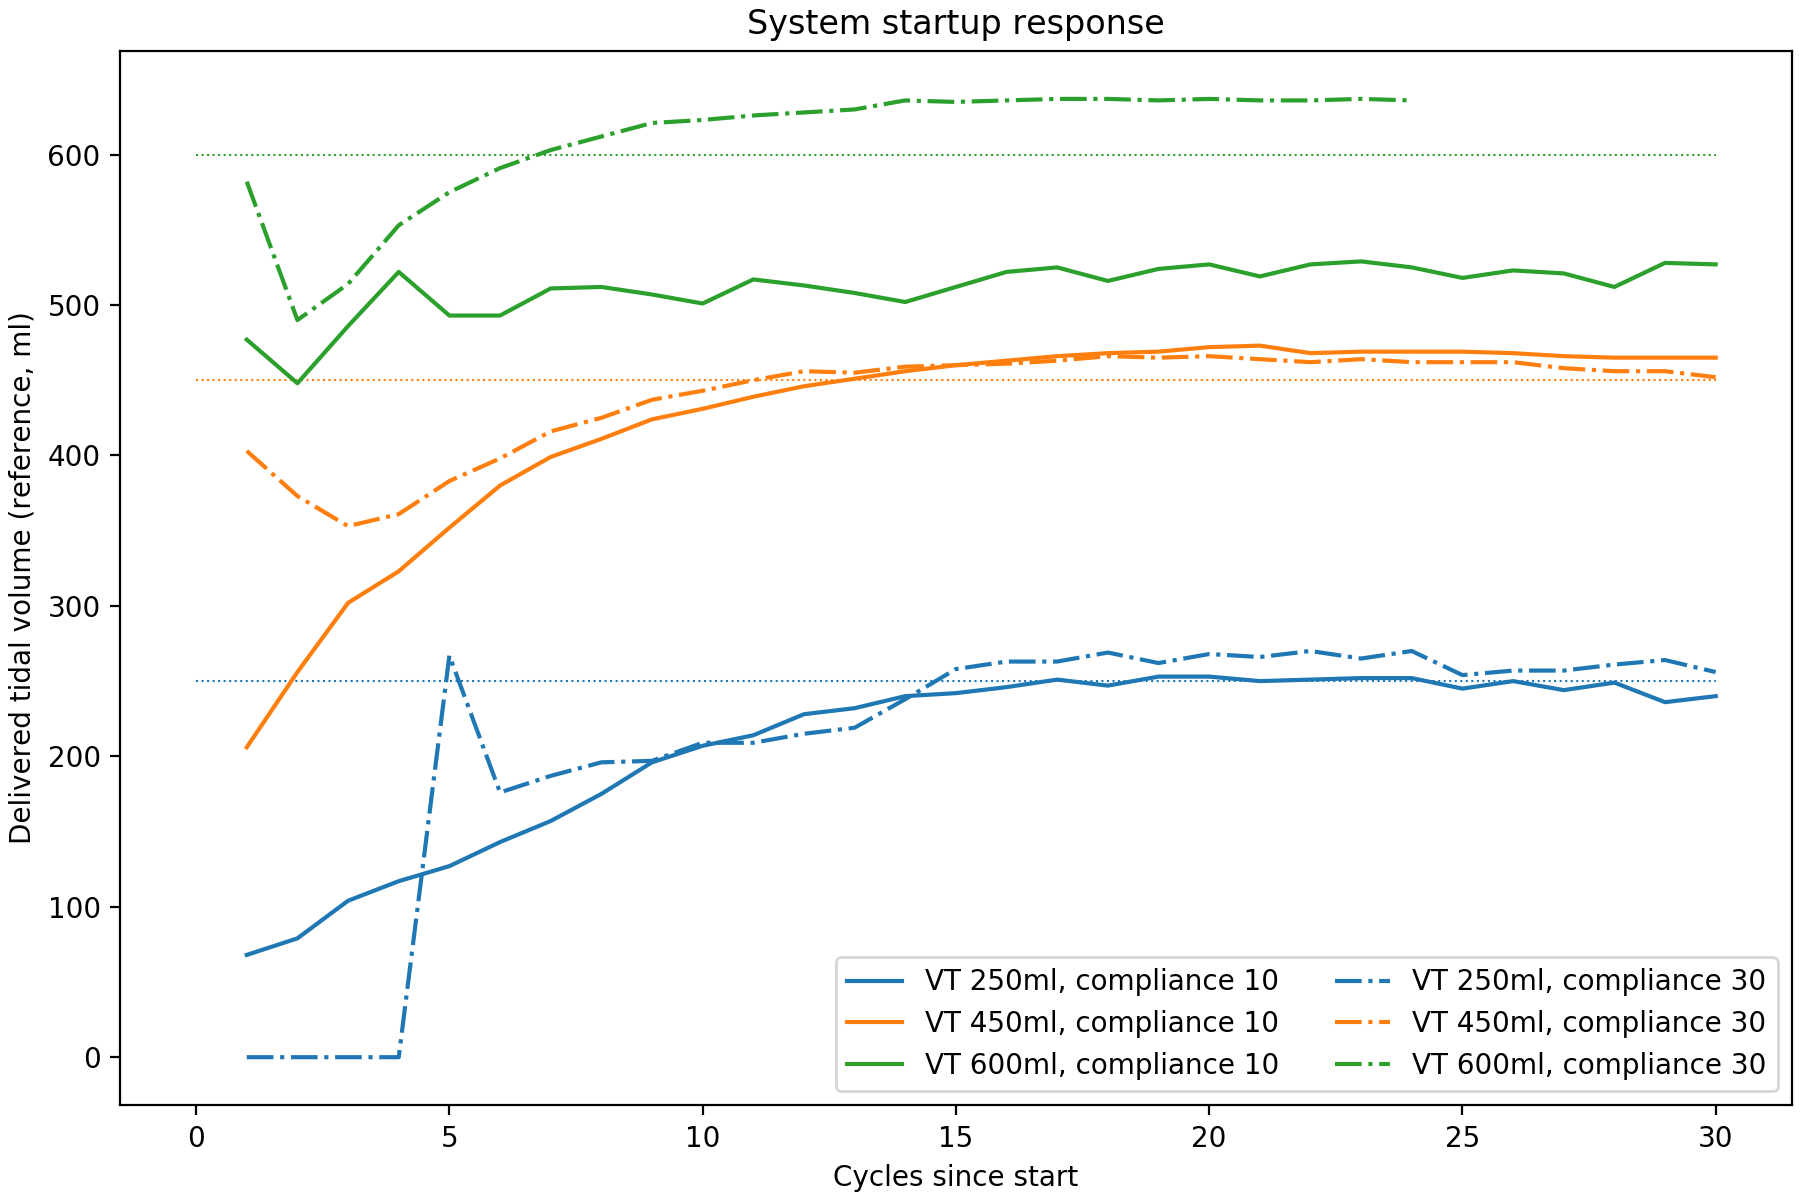

In [22]:
compliances = np.unique(lowflow_data["compliance"])
targets = np.unique(lowflow_data["target"])
lines = dict(zip(compliances, ['-', '-.']))

cmap = CMAP(np.linspace(0,1,10))[:,None,:]
plt.figure(figsize=FIGSIZE, constrained_layout=True)

for idx,vt in enumerate(targets):
    plt.plot([0,30], [vt,vt], color=np.squeeze(cmap[idx]), linestyle=':', linewidth=0.75)
    
for idx,(comp,vt) in enumerate(itertools.product(compliances, targets)):
    data = lowflow_data.where((lowflow_data["compliance"] == comp) & (lowflow_data["target"] == vt))
    plt.plot(data["cycles"], data["reference"], color=np.squeeze(cmap[idx % 3]), 
             linestyle=lines[comp], label='VT {:.0f}ml, compliance {:.0f}'.format(vt, comp))

plt.ylabel("Delivered tidal volume (reference, ml)")
plt.xlabel("Cycles since start")
plt.title("System startup response")
plt.legend(ncol=2)
plt.show()

### System startup results 

Note that the reference tidal volume, not the OxVent measured value, is plotted. The results of this test are mixed. At typical settings, (400ml) the system performs well, reaching target in about 10 cycles (30s). Other targets only a few extra cycles to reach stability (if not target). Poor performance was observed on: 
1. 600ml, 10 compliance: low tidal volume due to pressure-limiting behaviour, so is reflective of correctly functioning safety features
2. 600ml, 30 compliance: high tidal volume due to poor calibration of internal flow measurement. This fits a general trend that was observed across devices with under-estimation of flow at high flow rates (leading to excessive tidal volumes) 
3. 250ml, 30 compliance: numerous empty cycles before ventilation started. This is because this configuration called for extremely low pressures in the vent box (small volume, flexible lung), and at these low pressures the Marshall valve that supplies the vent box does not perform as required (Harrison has since confirmed that the other model of Marshall valve does not behave in this way) 

## 6.9 Tidal volume delivery <a id='6.9'></a>

General test of consistency and accuracy of ventilation at typical settings: 
1. 250ml, 20RR, 1:2 IE ratio, 10 PEEP
2. 400ml, 20RR, 1:2 IE ratio, 10 PEEP 
3. 600ml, 20RR, 1:2 IE ratio, 10 PEEP

9 OxVents were tested, using the new calibration coefficients.

In [23]:
tidal_data = loaders.load(op.join(ROOT, 'tidal'), '.*.csv', 4, ('target', 'reference', 'oxvent'))
tidal_data['X2044_R30_018202'][::5]

dict_keys(['X2044_R30_018202', 'X2044_R30_622603', 'X2044_R30_622602', 'X2044_R30_622601', 'X2044_R35_018301', 'X2044_R30_622604', 'X2044_R35_018302', 'X2044_R30_017603'])


,target,reference,oxvent
0,400.0,461.0,397.0
5,400.0,462.0,405.0
10,600.0,671.0,596.0
15,600.0,673.0,601.0
20,250.0,286.0,253.0
25,250.0,286.0,248.0
30,250.0,286.0,249.0
35,250.0,297.0,263.0


Violin plots of all cycles across all devices at each tidal volume target. 

<IPython.core.display.Javascript object>


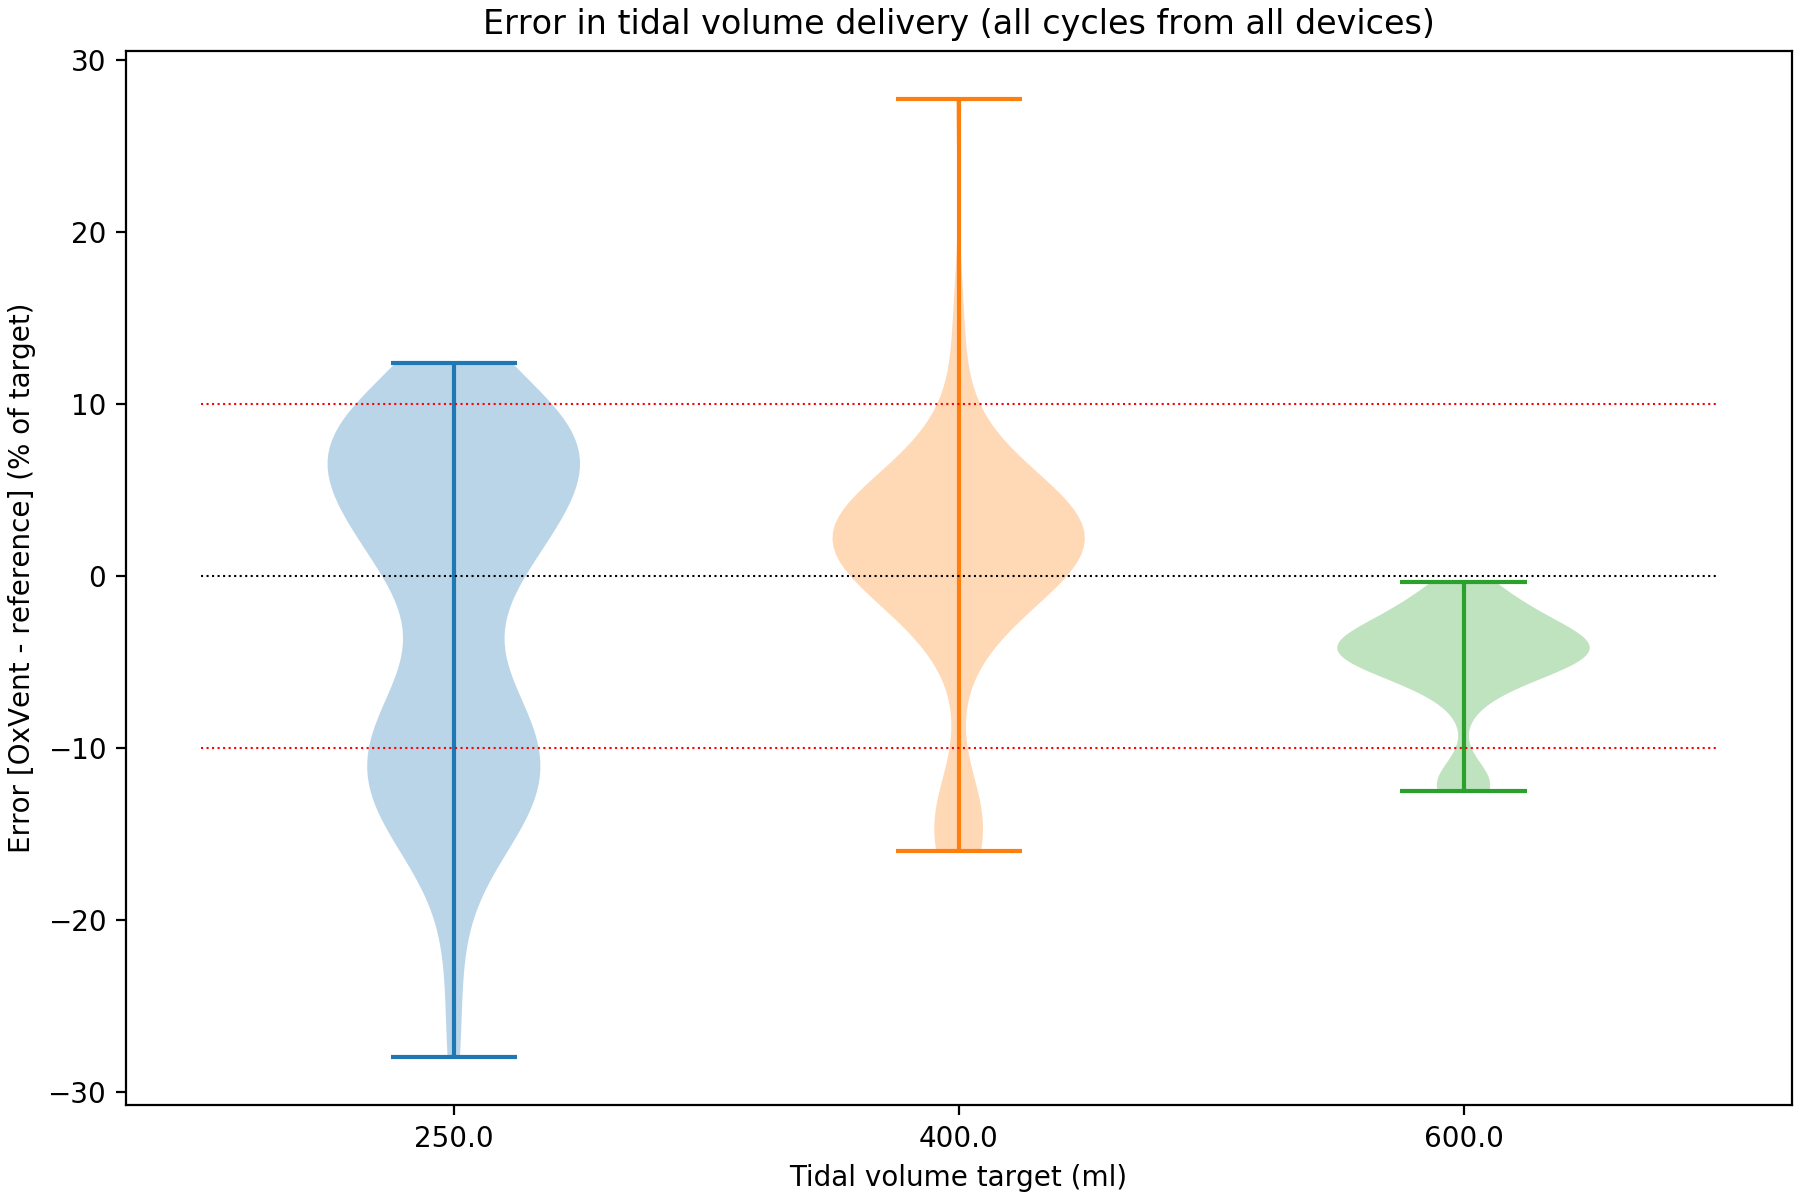

In [24]:
all_tidal = pd.concat(list(tidal_data.values()))

targets = np.unique(tidal_data[(next(iter(tidal_data)))]['target'])
cmap = CMAP(np.linspace(0,1,len(tidal_data)))[:,None,:]
fig = plt.figure(figsize=FIGSIZE, constrained_layout=True)

for vtidx, vt in enumerate(targets): 
    data = all_tidal.loc[all_tidal["target"] == vt,:]
    err = 100 * (data["oxvent"] - data["reference"]) / vt
    plt.violinplot([err], [vtidx], vert=True)
        
plt.plot([-0.5, targets.size-0.5], [0,0], 'k:', linewidth=0.75)
for bnd in [-10,10]:
    plt.plot([-0.5, targets.size-0.5], [bnd,bnd], 'r:', linewidth=0.75)

plt.xticks(range(targets.size), targets)
plt.xlabel("Tidal volume target (ml)")
plt.ylabel("Error [OxVent - reference] (% of target)")
plt.title("Error in tidal volume delivery (all cycles from all devices)")
plt.show()

### Tidal volume results

Error wrt. target is plotted for all cycles at each target. The dashed red lines indicate ±10% around target. Results at 250ml were poor, erring on the low side. This arises due to poor function of the Marshall valve supplying the vent box at low pressures, and possibly the non-linear response of the bag to compression, and is further discussed at the end of this report. Results at 400ml were generally acceptable but there were notable outliers (almost 30% above target). Results at 600ml were the most consistent of all, though this is probably because all devices were running right up against their limits (evidenced by the fact all devices came in under target). 

**It would be a good idea to repeat this test in Oxford once the points at the end of this report have been addressed**. We had to rush the acquisition of this data, and whilst it is certainly indicative of high-level trends that we observed on the devices, I wouldn't regard it as a "clean" run by any means. 

## 6.10 Ambu bag durability <a id='6.10'></a>

We were not able to test this as no multi-use bags were available for testing. We did have a single device running at high stress throughout our time in Hull (600ml, 27 RR, 1:2 IE, 10 PEEP) and no degradation was observed.  

## 6.11 Temperature and humidity <a id='6.11'></a>

We were not able to test this. 

## 6.12 Variation in supply voltage <a id='6.12'></a>

The purpose of this test was to check system operation with reduced supply voltage. The system was run in a high-stress configuration and supply voltage was reduced in steps.  Note that in order to perform this test we had to disconnect the UPS from the board and wire in a bench supply.

600ml, RR 25, PEEP 5, IE 1:2, Plimit 45. 

In [25]:
volt_data = loaders.load(op.join(ROOT, 'voltage'), 'SMC.csv', 4, ('volts', 'target', 'actual'))['SMC']
volt_data[::10]

dict_keys(['SMC'])


,volts,target,actual
0,24.0,600.0,602.0
10,24.0,600.0,605.0
20,23.0,600.0,602.0
30,22.0,600.0,576.0
40,22.0,600.0,588.0
50,21.0,600.0,531.0


Plot error in tidal volume wrt. target at each supply voltage. These are violin plots over the individual respiration cycles recorded at each voltage. 

<IPython.core.display.Javascript object>


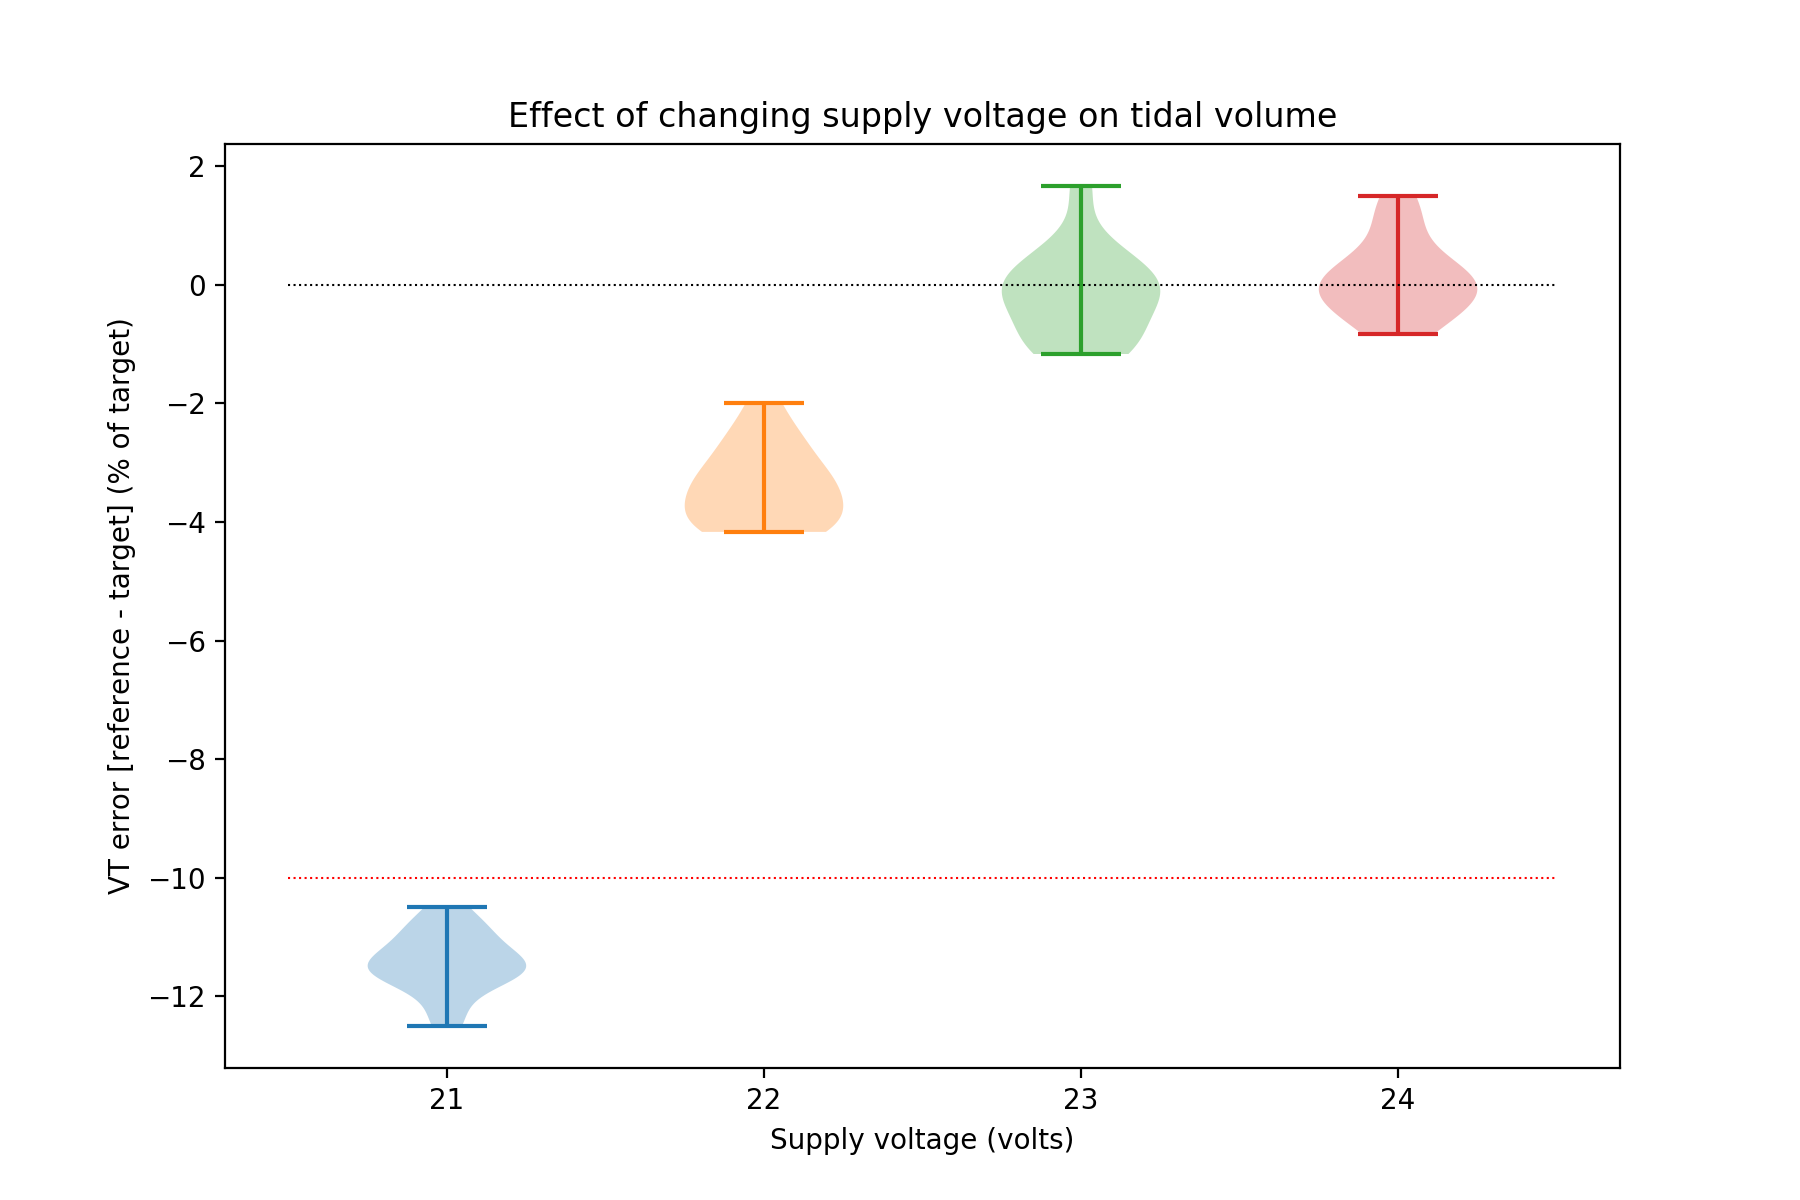

In [26]:
volts = np.unique(volt_data["volts"])
cmap = CMAP(np.linspace(0,1,10))[:,None,:]
fig = plt.figure(figsize=FIGSIZE)

plt.plot([volts.min()-0.5, volts.max()+0.5], [0,0], 'k:', linewidth=0.75)
plt.plot([volts.min()-0.5, volts.max()+0.5], [-10,-10], 'r:', linewidth=0.75)

for idx,volt in enumerate(volts):
    data = volt_data.loc[volt_data["volts"] == volt,:]
    err = 100 * (data["actual"] - data["target"]) / data["target"]
    plt.violinplot([err], [volt], vert=True)

plt.title('Effect of changing supply voltage on tidal volume')
plt.ylabel('VT error [reference - target] (% of target)')
plt.xlabel('Supply voltage (volts)')
plt.xticks(volts)
plt.show()

### Supply voltage results

The bound of 10% below target is shown in dashed red. Correct operation was observed at 24/23V, a small decrease in tidal volume delivery was observed at 22V (around 3% error), and at 21V the system was operating just below the boundary of acceptable behaviour (~11% error).

## 6.13 Variation in supply pressure <a id='6.13'></a>

The purpose of this test was to check system operation with varying supply pressue. 

- Settings for decreasing pressure: 600ml, RR 25, PEEP 5, IE 1:2
- Settings for increasing pressure: 250ml, RR 15, PEEP 10, I:E 1:2

In [27]:
air_data = loaders.load(op.join(ROOT, 'pressure_drop'), '.*SMC.csv', 4, ('pressure', 'target', 'actual'))
air_data = pd.concat(list(air_data.values()))
air_data[::15]

dict_keys(['DV613_MAX_SMC', 'DV613_MIN_SMC'])


,pressure,target,actual
0,4.0,450.0,440.0
15,4.5,450.0,458.0
30,5.0,450.0,460.0
45,5.5,450.0,454.0
60,6.0,450.0,440.0
0,4.0,600.0,592.0
15,3.5,600.0,536.0
30,3.0,600.0,451.0


Violin plots over all the cycles at each supply pressure. 

<IPython.core.display.Javascript object>


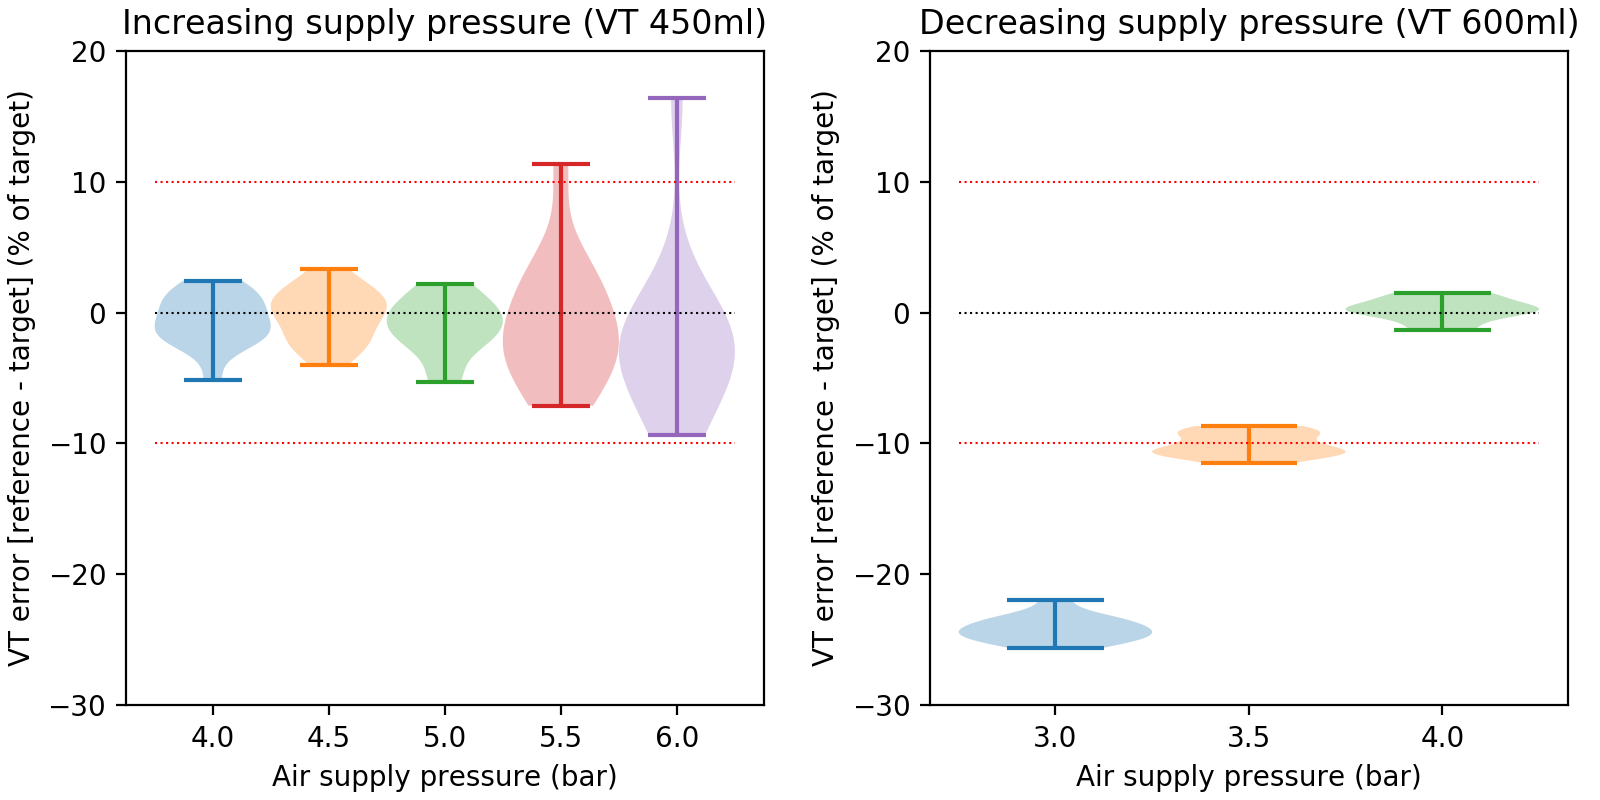

In [28]:
vts = np.unique(air_data["target"])
cmap = CMAP(np.linspace(0,1,10))[:,None,:]
fig, axes = plt.subplots(1, vts.size, figsize=(8,4), constrained_layout=True)

for vtidx,(vt,ax) in enumerate(zip(vts, axes)):
    psupp = np.unique(air_data["pressure"][air_data["target"] == vt])
    ax.plot([psupp.min()-0.25, psupp.max()+0.25], [0,0], 'k:', linewidth=0.75)
    ax.plot([psupp.min()-0.25, psupp.max()+0.25], [10,10], 'r:', linewidth=0.75)
    ax.plot([psupp.min()-0.25, psupp.max()+0.25], [-10,-10], 'r:', linewidth=0.75)

    for idx,ps in enumerate(psupp):
        data = air_data[(air_data["pressure"] == ps) & (air_data["target"] == vt)]
        if not data.empty:
            err = 100 * (data["actual"] - vt) / vt
            ax.violinplot([err], [ps], vert=True)

    ax.set_xlabel('Air supply pressure (bar)')
    ax.set_ylabel('VT error [reference - target] (% of target)')
    ax.set_xticks(psupp)
    ax.set_ylim(-30, 20)
    
axes[0].set_title('Increasing supply pressure (VT 450ml)')
axes[1].set_title('Decreasing supply pressure (VT 600ml)')
plt.show()

### Supply pressure results

Target volume is shown by a black dotted line, the ±10% error bounds are shown with red dotted lines. Unsurprisingly, the system struggles to deliver high-stress ventilation with falling supply pressure, though at 3.5bar the error wrt. target is around 10%, just on the bounds of acceptable behaviour. The system generally functioned well with increasing supply pressure, though there were individual high-volume deliveries at 5.5 and 6bar respectively (max 15% above target, at 6bar). The increased negative VT error at high pressure is likely due to the control loop overshooting when trying to restore to the target volume.

## Other observations <a id='other'></a>

1. Vertical/horizontal position of the unit. If the unit is switched on and goes through calibration in either a horizontal or vertical position, and is subsequently moved to the other position during operation, a large error in tidal volume measurement can be seen (easily > 10% of reference). 

2. Alarm. The alarm adds significant noise into the signal from the differential pressure sensor, but testing has shown that this is white noise with a random distribution and can therefore be mitigated into two ways: a) averaging over many samples (as is currently the case) and b) disabling alarm noises during inspiration, when accurate flow measurements are of paramount importance. Although (a) is a good start, we would definitely recommend implementing (b) as there is still an measurable error in measurement with (a) in isolation. The importance of this increases at low-flow operation as the SNR is poorer, hence the potential for error is greater. 

3. Dependence of flow measurement on PEEP. We observed a dependence of tidal volume measurement on PEEP for fixed operating parameters. In particular, at low PEEP (< 5 cmH2O), differences in excess of 10% of target were observed, whereas for PEEP settings of ~10 the differences were much reduced, *for the same RR and VT target*. This could be another alarm-related noise issue: for lower PEEPs, the voltage signals produced by the pressure sensors will be weaker, hence the SNR will decrease (assuming the alarm adds in noise of relatively fixed magnitude). Nevertheless, averaging over many samples should correct for this, so the true cause remains an open question. 

4. PEEP valves are highly ambiguous components. The numbers on the devices have a poor relation to the pressures they produce in the airway, and for long expiration times / small tidal volumes it is essentially impossible to maintain any significant PEEP (due to the leakiness of many components in the airway system). No doubt this will not be news to any clinicans, nor will they not think this of great significance, but as we have seen in the past, we cannot assume the same frontline/hands-on attitude from regulators so this is worth bearing in mind. 

5. The Marshall valve does itself have a measurable effect on accuracy of tidal volume delivery, as does the angular position of the interface between the valve and the spiro kit (both are tubular, so there are 360deg of alignment between the two). Although one could dig into the details and identify which of the two components is the source of greater variability, I think from a system point of view we may be better regarding them as one fixed assembly and testing both together. This is more relevant for clinical use: after all, every system comes with one spiro connected into one valve, they are not meant to be separated during the liftime of the system, so it is their joint properties that will determine the accuracy of the overall system. We also observed the valve that supplies the vent box itself (not the spiro) not behaving as required at low pressures, leading to a total loss of ventilation around ~250ml <14 RR. **Harrison has since tested an alternative design of Marshall valve and found better behaviour, so going forwards these should be used.**

6. Hysterisis. As mentioned in the above point, low-flow ventilation can be extremely unreliable in the current setup. We also noted a significant hysterisis effect that we have not been able to explain. For a target of 250 ml, 10RR, 1:2 IE ratio, the system is much more likely to achieve stability if it is started at default settings (400ml 20RR) and then adjusted *down* to the new target. By contrast, if the system is switched on and the target is entered before starting ventilation, the system has very little chance of reaching stability from a standing start. This could be hysterisis in software or hardware. 
